<a href="https://colab.research.google.com/github/franceslawley/Machine-Learning-Stroke-Prediction/blob/main/Final_Project_Lawley_Frances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Machine Learning Final Project**

# **Data Wrangling**

In [1]:
#Import Packages

import pandas as pd
import numpy as np
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [ ]:
#Load Data

pd.set_option('display.max_columns', None)
data = pd.read_csv('stroke.csv')
df = pd.DataFrame(data)
df.columns = ["ID", "Gender", "Age", "Hypertension", "Heart Disease", "Ever Married", "Work Type", "Residence Type", "Avg. Glucose Level", "BMI", "Smoking Status", "Stroke"]

print(df.info())
print(df.shape) 
#print(df.isnull().sum())
print(df.isnull().sum() / len(df) * 100)

plt.figure(figsize=(20,10))
sb.heatmap(df.corr(),annot=True)
#df.corr()

#5110 rows, 12 columns
#bmi is only feature with 201 null values, or 3.9% null values
#bmi has second lowest correlation (0.04) to our target variable 'stroke'
#id has the lowest correlation (0.006) to our target varialbe 'stroke' --> will not include id column 

In [ ]:
#Categorical Features
categorical_features = [features for features in df.columns if df[features].dtype == 'int64']
print('Number of categorical features: ', len(categorical_features)-1, categorical_features[1:4])

#Continuous Features
continuous_features = [features for features in df.columns if df[features].dtype == 'float']
print('Number of continuous features: ', len(continuous_features), continuous_features)

In [ ]:
#DROP id column (no predicting power)
df_stroke = df.drop(columns=['ID'])

#REMOVE rows with missing BMI values
df_stroke = df_stroke.dropna(subset=['BMI'])
pd.set_option('display.max_rows', None)
print(df_stroke.info())

#df_stroke['BMI'] = df_stroke['BMI'].fillna(df_stroke['BMI'].median()) --> could replace with median value but risky to assume

In [ ]:
#Plot count plots for non-continuous features

fig,axes = plt.subplots(4,2,figsize = (16,16))
plt.figure(figsize=(5,5))
sb.countplot(ax=axes[0,0], x='Gender', data = df_stroke)

sb.countplot(ax=axes[0,1], x='Hypertension', data = df_stroke)

sb.countplot(ax=axes[1,0], x='Heart Disease', data = df_stroke)

sb.countplot(ax=axes[1,1], x='Ever Married', data = df_stroke)

sb.countplot(ax=axes[2,0], x='Work Type', data = df_stroke)

sb.countplot(ax=axes[2,1], x='Residence Type', data = df_stroke)

sb.countplot(ax=axes[3,0], x='Smoking Status', data = df_stroke)

sb.countplot(ax=axes[3,1], x='Stroke', data = df_stroke)

plt.show()

In [ ]:
#Plot histogram for continuous features
continuous_features = [features for features in df.columns if df[features].dtype == 'float']

for features in continuous_features:
  plt.figure(figsize=(5,5))
  data = df_stroke.copy()
  data[features].hist(bins=25)
  plt.xlabel(features)
  plt.ylabel('Stroke')
  plt.grid(False)
  plt.show()

#We can see that Avg. Glucose Level and BMI are right skewed

# **Data Modeling**

In [7]:
#Create X/Y and Split into Train/Test

X = df_stroke.iloc[:, 0:-1]
y = df_stroke.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
#Baseline classification accuracy 

from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_classifier.fit(X_train,y_train)
baseline_acc = dummy_classifier.score(X_test,y_test)
print("Baseline Accuracy = ", baseline_acc)

In [ ]:
#Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error

#Set Dummy Variables
df_dummies = pd.get_dummies(df_stroke[['Gender', 'Ever Married', 'Work Type', 'Residence Type', 'Smoking Status']])
df_stroke2 = pd.concat([df_stroke,df_dummies],axis=1)

#Drop old columns and 'Gender_Other' column (all 0 values)
df_stroke2 = df_stroke2.drop(columns=['Gender', 'Ever Married', 'Work Type', 'Residence Type', 'Smoking Status'])
df_stroke2 = df_stroke2.drop(columns=['Gender_Other'])
#print(df_stroke.info())

#Make model, fit, predict
X = df_stroke2[['Age', 'Hypertension', 'Heart Disease', 'Avg. Glucose Level', 'BMI', 
                'Gender_Female', 'Gender_Male', 'Ever Married_No',
       'Ever Married_Yes', 'Work Type_Govt_job', 'Work Type_Never_worked',
       'Work Type_Private', 'Work Type_Self-employed', 'Work Type_children',
       'Residence Type_Rural', 'Residence Type_Urban',
       'Smoking Status_Unknown', 'Smoking Status_formerly smoked',
       'Smoking Status_never smoked', 'Smoking Status_smokes']]
y = df_stroke2['Stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
print(X_train.shape)
print(X_test.shape)


linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)

#linear_average = accuracy_score(y_test, linear_pred)
print('Test score:', linear_model.score(X_test, y_test))
print('Train score:', linear_model.score(X_train, y_train))
print('Model score:', linear_model.score(X_test, linear_pred))
rmse = np.sqrt(mean_squared_error(y_test, linear_pred))
print('Root mean squared error: ',rmse) 

visualizer = ResidualsPlot(linear_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

#We can see this is not a great linear model

In [ ]:
#Logistic Regression Model

from sklearn.linear_model import LogisticRegression

#Make model, fit, predict
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)
print('Logistic Regression Accuracy Score: ',accuracy_score(y_test, logistic_pred))

matrix = metrics.confusion_matrix(y_test, logistic_pred)
print(matrix)
metrics.plot_confusion_matrix(logistic_model, X_test, y_test)
plt.grid(False)
#print(metrics.accuracy_score(y_test, logistic_pred))

In [ ]:
#Decision Tree Model

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics

#Make model, fit, predict
dt_model = DecisionTreeClassifier(max_features=len(X.columns), max_depth=5,  random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

matrix = metrics.confusion_matrix(y_test, dt_pred)
print(matrix)
print('Decision Tree Model Score: ',metrics.accuracy_score(y_test, dt_pred))
print(metrics.classification_report(y_test,dt_pred))

plt.figure()
plt.figure(figsize=(20,10))
DT = tree.plot_tree(dt_model, filled = True)
#DT = tree.plot_tree(dt_model, feature_names = X.columns, class_names = y.unique(), filled = True)
plt.show()

imp = pd.DataFrame(zip(X_train.columns, dt_model.feature_importances_))
sorted = imp.sort_values(by = 1, ascending = False)
print('Top three most important features are:', sorted[0:3])

In [ ]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_features=len(X.columns), max_depth=5,  random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

matrix = metrics.confusion_matrix(y_test, rf_pred)
print(matrix)
print('Random Forest Model Score: ',metrics.accuracy_score(y_test, rf_pred))
print(metrics.classification_report(y_test,rf_pred))

imp = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_))
sorted = imp.sort_values(by = 1, ascending = False)
print('Top three most important features are:', sorted[0:3])

#print_recall_scores(rf_model, X_test, y_test)

In [ ]:
#Bagging Method

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

base_est = DecisionTreeClassifier(max_depth =5, max_features=len(X.columns), random_state = 42)
bagged_model = BaggingClassifier(base_estimator = base_est, random_state=42)
bagged_model.fit(X_train, y_train)
pred_bagged = bagged_model.predict(X_test)
acc_bagged = accuracy_score(y_test, pred_bagged)
print('Bagging Accuracy = ', acc_bagged)

matrix = metrics.confusion_matrix(y_test, pred_bagged)
print(matrix)
print('Bagging Score: ',metrics.accuracy_score(y_test, pred_bagged))
print(metrics.classification_report(y_test,pred_bagged))

#acc_bagging = round(metrics.accuracy_score(y_test, pred_bagged),4)
#print('Bagging Accuracy = ', acc_bagging)

In [ ]:
#Support Vector 

from sklearn import svm

supportvector_model = svm.SVC(random_state=42)
supportvector_model.fit(X_train, y_train)
supportvector_pred = supportvector_model.predict(X_test)

matrix = metrics.confusion_matrix(y_test, supportvector_pred)
print(matrix)
print('Support Vector Score: ',metrics.accuracy_score(y_test, supportvector_pred))
print(metrics.classification_report(y_test,supportvector_pred))
#print('Support Vector Accuracy Score: ',accuracy_score(y_test, supportvector_pred))

#**Data Wrangling Part 2**


In [ ]:
#Data Wrangling Part 2

#4700 non-stroke values and 409 stroke values (very uneven datatset)
print(len(df_stroke[df_stroke['Stroke']==0]))
print(len(df_stroke[df_stroke['Stroke']==1]))

balance1 = df_stroke[df_stroke["Stroke"]==1].sample(n=209, replace=False)
balance1.reset_index(drop=True, inplace=True)

balance0 = df_stroke[df_stroke["Stroke"]==0].sample(n=209, replace=False)
balance0.reset_index(drop=True, inplace=True)

balance_df= pd.concat([balance1, balance0], axis=0, join='outer')

print("Rows containing 0 = ", len(balance_df[balance_df["Stroke"]==0]))
print("Rows containing 1 = ", len(balance_df[balance_df["Stroke"]==1]))

In [13]:
X = balance_df.iloc[:, 0:-1]
y = balance_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
#Baseline classification accuracy 

from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_classifier.fit(X_train,y_train)
baseline_acc = dummy_classifier.score(X_test,y_test)
print("Baseline Accuracy = ", baseline_acc)

#**Modeling Part 2**

In [ ]:
#Linear Regression Model (with balanaced dataset)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error

#Set Dummy Variables
df_dummies = pd.get_dummies(balance_df[['Gender', 'Ever Married', 'Work Type', 'Residence Type', 'Smoking Status']])
balance_df2 = pd.concat([balance_df,df_dummies],axis=1)

#Drop old columns and 'Gender_Other' column (all 0s)
balance_df2 = balance_df2.drop(columns=['Gender', 'Ever Married', 'Work Type', 'Residence Type', 'Smoking Status'])
print(balance_df2.columns)

#Make model, fit, predict
X = balance_df2[['Age', 'Hypertension', 'Heart Disease', 'Avg. Glucose Level', 'BMI', 
                'Gender_Female', 'Gender_Male', 'Ever Married_No',
       'Ever Married_Yes', 'Work Type_Govt_job', 'Work Type_Private', 'Work Type_Self-employed', 'Work Type_children',
       'Residence Type_Rural', 'Residence Type_Urban',
       'Smoking Status_Unknown', 'Smoking Status_formerly smoked',
       'Smoking Status_never smoked', 'Smoking Status_smokes']]
y = balance_df2['Stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
print(X_train.shape)
print(X_test.shape)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)

#linear_average = accuracy_score(y_test, linear_pred)
print('Test score:', linear_model.score(X_test, y_test))
print('Train score:', linear_model.score(X_train, y_train))
print('Model score:', linear_model.score(X_test, linear_pred))
rmse = np.sqrt(mean_squared_error(y_test, linear_pred))
print('Root mean squared error: ',rmse) 

visualizer = ResidualsPlot(linear_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

In [ ]:
#Logistic Regression Model (with balanced dataset)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#Make model, fit, predict
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)
print('Logistic Regression Accuracy Score: ',accuracy_score(y_test, logistic_pred))

matrix = metrics.confusion_matrix(y_test, logistic_pred)
print(matrix)
metrics.plot_confusion_matrix(logistic_model, X_test, y_test)
plt.grid(False)
#print(metrics.accuracy_score(y_test, logistic_pred))

In [ ]:
#Decision Tree Model (with balanced dataset)

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics

#Make model, fit, predict

dt_model = DecisionTreeClassifier(max_features=len(X.columns), max_depth=5,  random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

matrix = metrics.confusion_matrix(y_test, dt_pred)
print(matrix)
print('Decision Tree Model Score: ',metrics.accuracy_score(y_test, dt_pred))
print(metrics.classification_report(y_test,dt_pred))

plt.figure()
plt.figure(figsize=(20,10))
DT = tree.plot_tree(dt_model, filled = True)
#DT = tree.plot_tree(dt_model, feature_names = X.columns, class_names = y.unique(), filled = True)
plt.show()

imp = pd.DataFrame(zip(X_train.columns, dt_model.feature_importances_))
sorted = imp.sort_values(by = 1, ascending = False)
print('Top three most important features are:', sorted[0:3])

In [ ]:
#Random Forest (with balanced dataset)

from sklearn.ensemble import RandomForestClassifier
X = balance_df2[['Age', 'Hypertension', 'Heart Disease', 'Avg. Glucose Level', 'BMI', 
                'Gender_Female', 'Gender_Male', 'Ever Married_No',
       'Ever Married_Yes', 'Work Type_Govt_job', 'Work Type_Private', 'Work Type_Self-employed', 'Work Type_children',
       'Residence Type_Rural', 'Residence Type_Urban',
       'Smoking Status_Unknown', 'Smoking Status_formerly smoked',
       'Smoking Status_never smoked', 'Smoking Status_smokes']]
y = balance_df2['Stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

rf_model = RandomForestClassifier(n_estimators=100, max_features=len(X.columns), max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

matrix = metrics.confusion_matrix(y_test, rf_pred)
print(matrix)
print('Random Forest Model Score: ',metrics.accuracy_score(y_test, rf_pred))
print(metrics.classification_report(y_test,rf_pred))

#performs better than decision tree balanced dataset score
#even though decision tree/random forest scores are initially very similar without balanced dataset!

imp = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_))
sorted = imp.sort_values(by = 1, ascending = False)
print('Top three most important features are:', sorted[0:3])

In [ ]:
#Bagging Method (with balanced dataset)

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

base_est = DecisionTreeClassifier(max_depth =5, max_features=len(X.columns), random_state = 42)
bagged_model = BaggingClassifier(base_estimator = base_est, random_state=42)
bagged_model.fit(X_train, y_train)
pred_bagged = bagged_model.predict(X_test)
acc_bagged = accuracy_score(y_test, pred_bagged)
print('Bagging Accuracy = ', acc_bagged)
matrix = metrics.confusion_matrix(y_test, pred_bagged)
print(matrix)
print('Bagging Score: ',metrics.accuracy_score(y_test, pred_bagged))
print(metrics.classification_report(y_test,pred_bagged))

In [ ]:
#Support Vector (with balanced dataset)

from sklearn import svm
X = balance_df2[['Age', 'Hypertension', 'Heart Disease', 'Avg. Glucose Level', 'BMI', 
                'Gender_Female', 'Gender_Male', 'Ever Married_No',
       'Ever Married_Yes', 'Work Type_Govt_job', 'Work Type_Private', 'Work Type_Self-employed', 'Work Type_children',
       'Residence Type_Rural', 'Residence Type_Urban',
       'Smoking Status_Unknown', 'Smoking Status_formerly smoked',
       'Smoking Status_never smoked', 'Smoking Status_smokes']]
y = balance_df2['Stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

supportvector_model = svm.SVC()
supportvector_model.fit(X_train, y_train)
supportvector_pred = supportvector_model.predict(X_test)

matrix = metrics.confusion_matrix(y_test, supportvector_pred)
print(matrix)
print('Support Vector Score: ',metrics.accuracy_score(y_test, supportvector_pred))
print(metrics.classification_report(y_test,supportvector_pred))
#print('Support Vector Accuracy Score: ',accuracy_score(y_test, supportvector_pred))

# **Cross Validation**

In [ ]:
#Lasso CV

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import cross_val_score

alpha_space = np.logspace(-4, 0, 50)
model_scores = []

lasso_model = Lasso(normalize=True)
for alpha in alpha_space:

    # Specify the alpha value to use
    lasso_model.alpha = alpha
    
    # Perform 10-fold CV
    lasso_cv_scores = cross_val_score(lasso_model,X,y,cv=10)
    
    # Append the mean of lasso_cv_scores to model_scores = []
    model_scores.append(np.mean(lasso_cv_scores))

print(model_scores)
print(np.argmax(model_scores)) #returns index of the highest model_score (best alpha value)
print(alpha_space[8]) #plug in argmax index

In [ ]:
#Lasso CV

from sklearn.linear_model import Lasso

alpha_user = 0.0016768329368110067 #play with alpha and you will get different results (between 0 and 1)
lasso_model = Lasso(alpha=alpha_user,normalize=True)
lasso_model.fit(X_train,y_train)
lasso_pred = lasso_model.predict(X_test)

print("Lasso Model Score:", lasso_model.score(X_test, y_test))
print("Lasso Model Coefficients:", lasso_model.coef_)

plt.plot(range(len(X.columns)), lasso_model.coef_)
plt.xticks(range(len(X.columns)), X.columns, rotation=60)
plt.show()

In [ ]:
#Graph Random Forest Train/Test Errors

from sklearn.ensemble import RandomForestRegressor
import seaborn as sns 

n_estimators = [10,20,50,100,200,250,300,350,500]

train_error = []
test_error = []

for i in n_estimators:
    regressor = RandomForestRegressor(n_estimators=i)
    regressor.fit(X_train, y_train)
    train_error.append(np.sqrt(mean_squared_error(y_train, regressor.predict(X_train))))
    test_error.append(np.sqrt(mean_squared_error(y_test, regressor.predict(X_test))))

plt.figure(figsize = (15, 10))
plt.title('Random Forest: Model Complexity vs RMSE', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
plt.xlabel('Number of Trees', fontsize=20)
print(train_error)
print(test_error)
sns.lineplot(n_estimators, train_error, label='Train')
sns.lineplot(n_estimators, test_error, color='r', label='Test')
plt.show()

In [ ]:
#Run AdaBoostClassifier to check if optimal number of n_estimators = 100

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    recall_score,
    precision_score,
    accuracy_score
)

ada_boost1 = AdaBoostClassifier(dt_model, n_estimators=50, random_state=42, learning_rate=.05)
ada_boost1.fit(X_train, y_train)
ada_boost2 = AdaBoostClassifier(dt_model, n_estimators=100, random_state=42, learning_rate=.05)
ada_boost2.fit(X_train, y_train)
ada_boost3 = AdaBoostClassifier(dt_model, n_estimators=500, random_state=42, learning_rate=.05)
ada_boost3.fit(X_train, y_train)
res1 = round(recall_score(y_test, ada_boost1.predict(X_test)), 4)
res2 = round(recall_score(y_test, ada_boost2.predict(X_test)),4)
res3 = round(recall_score(y_test, ada_boost3.predict(X_test)),4)

print('MODEL 1 Recall:\t {}'.format(res1))
print('MODEL 2 Recall:\t {}'.format(res2))
print('MODEL 3 Recall:\t {}'.format(res3))

In [23]:
#Random Forest - Cross Validation

#Create validation dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state = 42)

In [ ]:
#Random Forest - CV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

#Create, fit, predict model on train set
rf_model = RandomForestClassifier(n_estimators=100, max_features=len(X.columns), max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred2 = rf_model.predict(X_val)

#Cross Validation score
print("Cross Validation Score: ", cross_val_score(rf_model, X_val, y_val, cv=5, scoring='accuracy').mean())

matrix = metrics.confusion_matrix(y_val, rf_pred2)
print(matrix)

print('Random Forest Model Score: ',metrics.accuracy_score(y_val, rf_pred2))
print(metrics.classification_report(y_val,rf_pred2))

imp = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_))
sorted = imp.sort_values(by = 1, ascending = False)
print('Top three most important features are:', sorted[0:3])

In [ ]:
#Find the best max_depth and max_features to make model better

depth = []
features = []

for i in range(3,20):
  random_forest1 = RandomForestClassifier(n_estimators=100, max_depth=i)
  random_forest1 = random_forest1.fit(X_train, y_train)
  scores1 = cross_val_score(estimator = random_forest1, X=X_val, y = y_val, cv=10)
  depth.append((i,scores1.mean()))

  random_forest2 = RandomForestClassifier(n_estimators=100, max_features=i)
  random_forest2 = random_forest2.fit(X_train, y_train)
  scores2 = cross_val_score(estimator = random_forest2, X=X_val, y = y_val, cv=10)
  features.append((i,scores2.mean()))

print(depth)
print(features)

#Best depth: (19, 0.9023809523809524)
#Best features: (3, 0.8714285714285713)

In [ ]:
#Add new optimal depth and features
#Re-run model and calculate new cross validation score on new model

#rf_model_cv = RandomForestClassifier(n_estimators=100, max_features= 3, max_depth=19, random_state=42)
rf_model_cv = RandomForestClassifier(n_estimators=100, max_features= 3, max_depth=5, random_state=42) #Switch depth back from 19 to 5 and see if same results (keep model simple)
rf_model_cv.fit(X_train, y_train)
rf_pred_cv= rf_model_cv.predict(X_test)

print("Cross Validation Score: ", cross_val_score(rf_model_cv, X_val, y_val, cv=10, scoring='accuracy').mean())

acc_forest_cv = metrics.accuracy_score(y_test, rf_pred_cv)
print('Random Forest Accuracy after cross validation= ', acc_forest_cv)

Top three most important features:                     0         1
0                 Age  0.439179
3  Avg. Glucose Level  0.148564
4                 BMI  0.091025


Text(0.5, 1.0, 'Feature Importances')

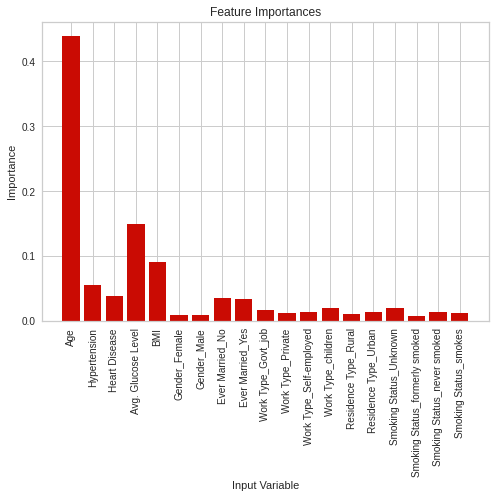

In [28]:
#Random Forest CV Model Results

feature_importances = rf_model_cv.feature_importances_
imp = pd.DataFrame(zip(X_train.columns, rf_model_cv.feature_importances_))
sorted = imp.sort_values(by = 1, ascending = False)
print('Top three most important features:', sorted[0:3])

x_values = list(range(len(feature_importances)))
plt.bar(x_values, feature_importances, orientation = 'vertical', color='r')
plt.xticks(x_values, X.columns, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Input Variable')
plt.title('Feature Importances')